In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from tqdm import tqdm

/usr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.device_count()

5

In [3]:
device = 'cuda:0' #torch.device(torch.cuda.get_device_name(1))

In [4]:
torch.cuda.device(1) #torch.device('cuda')

### Vanilla Autoencoder

In [5]:
class AutoMNIST(nn.Module):
    def __init__(self, in_features, out_features, n_classes=10):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_classes = n_classes
    
        self.encoder = nn.Sequential(nn.Dropout(0.1,),
                                     nn.Linear(in_features, in_features//2),
                                     nn.ReLU(),
                                     nn.Linear(in_features//2, in_features//4),
                                     nn.ReLU(),
                                     nn.Linear(in_features//4, out_features))
        
        self.decoder = nn.Sequential(nn.Linear(out_features, in_features//4),
                                     nn.ReLU(),
                                     nn.Linear(in_features//4, in_features//2),
                                     nn.ReLU(),
                                     nn.Linear(in_features//2, in_features))
        
        self.classifier = nn.Sequential(
                                     nn.Linear(out_features, out_features*2),
                                     nn.ReLU(),
                                     nn.Linear(out_features*2, out_features*4),
                                     nn.ReLU(),
                                     nn.Linear(out_features*4, n_classes))
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        y = self.classifier(encoded)
        return decoded, y

### Variational Autoencoder

In [6]:
class VAE(nn.Module):
    def __init__(self, in_features, out_features, beta=0.05):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.beta = beta
    
        self.encoder = nn.Sequential(nn.Dropout(0.1,),
                                     nn.Linear(in_features, in_features//2),
                                     nn.ReLU(),
                                     nn.Linear(in_features//2, in_features//4),
                                     nn.ReLU(),
                                     nn.Linear(in_features//4, out_features*2))
        
        self.decoder = nn.Sequential(nn.Linear(out_features, in_features//4),
                                     nn.ReLU(),
                                     nn.Linear(in_features//4, in_features//2),
                                     nn.ReLU(),
                                     nn.Linear(in_features//2, in_features))
        
    def forward(self, x):
        B, _ = x.shape
        #transform
        x1 = self.encoder(x)
        # reparametrization trick
        mu, sigma = x1[::, 0:self.out_features], x1[::, self.out_features:]
        sample = torch.randn(B,self.out_features)
        x2 = sample*sigma + mu
        # distance of learned distribution N(mu,sigma) to N(0,I):
        sigma_sum = torch.sum(sigma**2, dim=1) 
        mu2 = torch.sum(mu*mu,dim=1) 
        log_s1_s2 = torch.log(torch.sum(sigma**2, dim=1))
        Dkl = sigma_sum + mu2 - log_s1_s2 - self.out_features
        
        # decode
        x3 = self.decoder(x2)
        
        return x3, torch.mean(Dkl)*self.beta

# Low Rank Autoencoder

### Low Rank autoencoder with additional linear layer

In [16]:
class LowRankAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins, n_classes=10):
        super().__init__()
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        self.eps = 1e-4/(out_features*n_bins)
        
        # coordinate grid vectors
        # rng = torch.arange(-n_bins//2,n_bins//2) + 0.5
        rng = torch.arange(n_bins)

#         sgn = torch.sign(rng)
#         self.range = rng*rng*sgn
        self.range = (rng /n_bins).to(device)

        # encoder
        self.encoder = nn.Sequential(nn.Linear(in_features, inter_features),
                                     nn.ELU(),
                                     )
        
        # mapping to final probabilities (штаны)
        self.layers = nn.ModuleList([nn.Sequential(
                                                   nn.Linear(inter_features, n_bins),
                                                   nn.Sigmoid()
                                                  )
                                                   for i in range(out_features)]
                                   )
        # dropout for randomized sampling
        self.dropout = nn.Dropout(0.3)
        # decoder
        self.decoder = nn.Sequential(nn.Linear(out_features, inter_features),
                                     nn.ELU(),
                                     nn.Linear(inter_features, in_features),
                                     )
        # classifier
        self.classifier = nn.Sequential(
                                     nn.Linear(out_features, out_features*2),
                                     nn.ReLU(),
                                     nn.Linear(out_features*2, out_features*4),
                                     nn.ReLU(),
                                     nn.Linear(out_features*4, n_classes))
        
    # even faster forward - inner products with the range vec
    def forward(self,x):
        B = x.shape[0]
        # encoding
        pre_factors = self.encoder(x) # size = (B, inter_features)
        # getting additional linear layer
        factors_list = []
        for layer in self.layers:
            factors_list.append(layer(pre_factors)) # (B, n_bins)
        # stack  them up
        factors = torch.stack(factors_list, dim=-1)
        new_factors = factors.view(B, self.out_features, self.n_bins) # size = (B, out_features, n_bins)
        new_factors = new_factors/(torch.sum(new_factors, dim=-1, keepdim=True))
        # randomized selection + added eps
        # dropped_factors = self.dropout(new_factors) + self.eps
        dropped_factors = new_factors
        # normalization
        normalized_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
        # matrix-vector product of factors=(B,out_features,n_bins) with range=(n_bins)
        
        # original version - NORMALIZING
        # encoded = normalized_factors @ self.range 

        # SOFTMAX version
        cumsum_factors = torch.cumsum(normalized_factors, dim=-1) # cumsum over bins
        y = torch.rand(B, self.out_features,1).to(device)
        abs_factors = torch.abs(cumsum_factors - y)
        final_factors = torch.softmax(-100*abs_factors, dim=-1)
        encoded1 = final_factors @ self.range 

        # SOFTMAX + NORMALIZING
        dropped_factors = self.dropout(new_factors) + self.eps
        # normalization
        normalized_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
        encoded2 = normalized_factors @ self.range 

        weight = torch.rand(1)
        if weight > 0.5:
            encoded = encoded1
        else:
            encoded = encoded2


        # decoding
        decoded = self.decoder(encoded)
        # classification
        y_pred =  self.classifier(encoded)
        
        return y_pred, decoded, encoded, new_factors

In [17]:
LLL = LowRankAutoencoder(in_features=20, inter_features=5, out_features=2, n_bins=20).to(device)

ttt = torch.randn(16, 20).to(device)

y_pred, decoded, encoded, new_factors = LLL(ttt)
decoded.shape

torch.Size([16, 20])

# Convolutional autoencoder
## Up and Down Blocks

In [18]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity=nn.ELU()):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features,
                               kernel_size=5, stride=2, padding=2, dilation=1)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.nonlinearity(x1)
        return x2

In [19]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=2, nonlinearity=nn.ELU()):
        super().__init__()
        # self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear')
        self.upsample = nn.ConvTranspose2d(in_features, in_features,
                                            kernel_size=3, output_padding=1, padding=1, stride=2)
        self.conv = nn.Conv2d(in_features, out_features,
                               kernel_size=5, stride=1, padding=2, dilation=1)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.upsample(x)
        x2 = self.conv(x1)
        x3 = self.nonlinearity(x2)
        return x3

In [20]:
db = DownsampleBlock(in_features=8, out_features=8)
ttt = torch.rand(16,8,28,28)
db(db(db(ttt))).shape

torch.Size([16, 8, 4, 4])

In [21]:
ub = UpsampleBlock(in_features=8, out_features=8,)

ub(db(db(db(ttt)))).shape

torch.Size([16, 8, 8, 8])

In [22]:
class ConvEncoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins, img_size=(24,24)):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_bins = n_bins
        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        
        self.down = nn.Sequential(nn.Dropout(0.1),
                                  DownsampleBlock(in_features=1, out_features=32),
                                  DownsampleBlock(in_features=32, out_features=64),
                                  DownsampleBlock(in_features=64, out_features=64),)
        
        self.low_rank = LowRankAutoencoder(in_features=in_features,
                                           inter_features=inter_features,
                                           out_features=out_features,
                                           n_bins=n_bins,
                                           n_classes=10)
        
        self.up = nn.Sequential(UpsampleBlock(in_features=64, out_features=64),
                                UpsampleBlock(in_features=64, out_features=32),
                                UpsampleBlock(in_features=32, out_features=1, nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
#         print('x_flat', x_flat.shape)

        # low rank block
        y_pred, decoded, encoded, new_factors = self.low_rank(x_flat)
#         print('y_pred', y_pred.shape)
#         print('decoded', decoded.shape)
#         print('encoded', encoded.shape)
#         print('new_factors', new_factors.shape)
        
        

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return y_pred, x_out, encoded, new_factors
            
            

In [23]:
class ConvEncoderCelebA(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins, img_size=(64,64)):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_bins = n_bins
        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        
        self.down = nn.Sequential(#nn.Dropout(0.1),
                                  DownsampleBlock(in_features=3, out_features=128),
                                  DownsampleBlock(in_features=128, out_features=256),
                                  DownsampleBlock(in_features=256, out_features=512),
                                  DownsampleBlock(in_features=512, out_features=1024),
                                  )
        
        self.low_rank = LowRankAutoencoder(in_features=in_features,
                                           inter_features=inter_features,
                                           out_features=out_features,
                                           n_bins=n_bins,
                                           n_classes=10)
        
        self.up = nn.Sequential(UpsampleBlock(in_features=1024, out_features=512),
                                UpsampleBlock(in_features=512, out_features=256),
                                UpsampleBlock(in_features=256, out_features=128),
                                UpsampleBlock(in_features=128, out_features=3, nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
#         print('x_flat', x_flat.shape)

        # low rank block
        y_pred, decoded, encoded, new_factors = self.low_rank(x_flat)
#         print('y_pred', y_pred.shape)
#         print('decoded', decoded.shape)
#         print('encoded', encoded.shape)
#         print('new_factors', new_factors.shape)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return y_pred, x_out, encoded, new_factors

In [24]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

# According to NeurIPS 2020 paper
# - center crop 148x148
# - resize to 64x64
# - no normalization

celebA_all = torchvision.datasets.ImageFolder('celeba/', 
                                     transform=transforms.Compose([
                                  transforms.CenterCrop(148),
                                  transforms.Resize(64),
                                  transforms.ToTensor(),
#                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                                        std=[0.5, 0.5, 0.5])
                              ]))

# random split

n = len(celebA_all)  # total number of examples
n_test = int(0.025 * n)  # take ~10% for test
train_set = torch.utils.data.Subset(celebA_all, range(n_test, n))  # take the rest 
test_set = torch.utils.data.Subset(celebA_all, range(n_test))  # take first 10%


BATCH_SIZE = 1024
celeb_train_dl = DataLoader(train_set, batch_size=BATCH_SIZE,
                             num_workers=32)
celeb_test_dl = DataLoader(test_set, batch_size=BATCH_SIZE,
                            num_workers=32)

print(len(test_set))
print(len(train_set))

5064
197535


In [25]:
CAE_celeb = ConvEncoderCelebA(in_features=1024*4*4, inter_features=1024,
                              out_features=4, n_bins=20, img_size=(64,64)).to(device)

# ttt = torch.rand(20,3,64,64).to(device)
ttt = train_set[0][0].unsqueeze(0).to(device)


y_pred, x_out, encoded, new_factors = CAE_celeb(ttt)

new_factors.shape

torch.Size([1, 4, 20])

In [26]:
CAE = ConvEncoder(in_features=64*3*3, inter_features=128,
                   out_features=2, n_bins=20, img_size=(24,24)).to(device)

ttt = torch.rand(20,1,24,24).to(device)

y_pred, x_out, encoded, new_factors = CAE(ttt)

new_factors.shape

torch.Size([20, 2, 20])

### Dataset class

In [27]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [28]:
import torchvision

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 60000
TEST_SIZE = 5000
BATCH_SIZE = 512
# ds = MNIST_DS(X=train_ds_mnist.data[0:10000,5:-5,5:-5].reshape(-1,18*18), Y=train_ds_mnist.targets[0:10000])
ds = MNIST_DS(X=train_ds_mnist.data[0:TRAIN_SIZE,2:-2,2:-2], Y=train_ds_mnist.targets[0:TRAIN_SIZE])
dl = DataLoader(ds, batch_size=BATCH_SIZE)

ds_test = MNIST_DS(X=test_ds_mnist.data[0:TEST_SIZE,2:-2,2:-2], Y=test_ds_mnist.targets[0:TEST_SIZE])
dl_test = DataLoader(ds, batch_size=BATCH_SIZE)

#full dataset
# X_full = torch.tensor(train_ds_mnist.data[0:10000,5:-5,5:-5].reshape(-1,18*18), dtype=torch.float)
X_full = torch.tensor(train_ds_mnist.data[0:TRAIN_SIZE,2:-2,2:-2], dtype=torch.float)
X_full = X_full/torch.max(X_full)

# X_full_test = torch.tensor(test_ds_mnist.data[0:10000,5:-5,5:-5].reshape(-1,18*18), dtype=torch.float)
X_full_test = torch.tensor(test_ds_mnist.data[0:TEST_SIZE,2:-2,2:-2], dtype=torch.float)

X_full_test = X_full_test/torch.max(X_full_test)

targets = train_ds_mnist.targets[0:TRAIN_SIZE]
targets_test = test_ds_mnist.targets[0:TEST_SIZE]


print(X_full.shape)
print(torch.max(X_full))
print(targets.unique(return_counts=True))

/tmp/ipykernel_3645117/2790511928.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float)
/tmp/ipykernel_3645117/2790511928.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.long)
/tmp/ipykernel_3645117/4014540751.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_full = torch.tensor(train_ds_mnist.data[0:TRAIN_SIZE,2:-2,2:-2], dtype=torch.float)
/tmp/ipykernel_3645117/4014540751.py:29: UserWarning: To copy construct from a tensor, it is recommended to use 

torch.Size([60000, 24, 24])
tensor(1.)
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [29]:
torch.manual_seed(0)

In [31]:
# model = AutoMNIST(in_features=18*18, out_features=2)
# model = VAE(in_features=64, out_features=2, beta=0.1)
# model = LowRankAutoencoder(in_features=18*18, inter_features=128, out_features=2, n_bins=20)
torch.cuda.empty_cache()

model = ConvEncoder(in_features=64*3*3, inter_features=256,
                     out_features=8, n_bins=20, img_size=(24,24)).to(device)

# model = ConvEncoderCelebA(in_features=1024*4*4, inter_features=1024,
#                               out_features=32, n_bins=100, img_size=(64,64)).to(device)

criterion = nn.MSELoss()
cls_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [33]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()

loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0
i = 0
for epoch in tqdm(range(2000)):
    # Forward pass: Compute predicted y by passing x to the model
    
    for x_batch, y_batch in dl:
    # for x_batch, y_batch in celeb_train_dl:


        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        x_batch_noise = x_batch + torch.rand(x_batch.shape).to(device)/5
        y_pred, x_pred, enc, factors_prob = model(x_batch_noise.unsqueeze(1)) # conv autoencoder
        # y_pred, x_pred, enc, factors_prob = model(x_batch_noise) # conv autoencoder celeb

        
    
        loss1 = criterion(x_pred.view(-1), x_batch.view(-1)) #+ Dkl
        loss2 = cls_criterion(y_pred, y_batch)
        loss = loss1 #+ loss2*0.05
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                # for x_batch, y_batch in celeb_test_dl:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    ypred, x_pred, enc, f = model(x_batch.unsqueeze(1)) 
                    # ypred, x_pred, enc, f = model(x_batch) 

                    loss_test = criterion(x_pred.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                model.train() # put back to train
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
            
#         break
#     break

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [1:50:44<00:00,  3.32s/it]


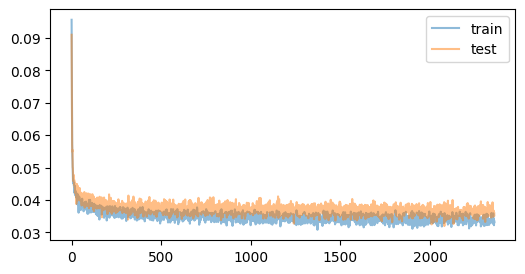

In [34]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig('MNIST_softmax_plus_loss.png')
plt.show()

### Reconstruction and distribution graphs

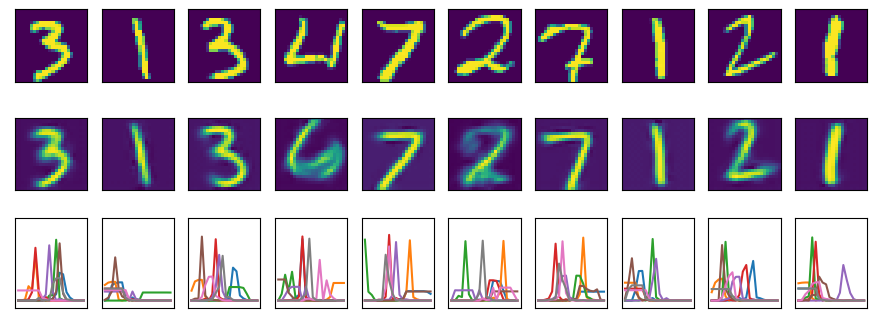

In [35]:
fig, axs = plt.subplots(3,10, figsize=(11,4))

for i in range(0,10):
    INDX=i+30
    #true
    
    #pred
    with torch.no_grad():
        model.eval()
        x_batch = X_full_test[INDX].unsqueeze(0).unsqueeze(0)
        # x_batch = train_set[INDX][0].unsqueeze(0)
#         x_batch = X_full_test[INDX].unsqueeze(1)
        
        # noise addition
        x_batch_noise = x_batch #+ torch.rand(x_batch.shape)/3
#         x_batch_noise = x_batch_noise/torch.max(x_batch_noise)
#         x_batch_noise = x_batch_noise/(torch.max(x_batch_noise, dim=1, keepdim=True)[0])
        
        # plotting original images
#         axs[0,i].imshow(x_batch_noise[0].reshape(18,18))
        axs[0,i].imshow(x_batch_noise[0,0]) # mnist
        # axs[0,i].imshow(np.transpose(x_batch_noise.cpu().detach().numpy()[0], (1,2,0))) # celeb
        
        
        ypred, out, enc, factors_prob = model(x_batch_noise.to(device))  
#         ypred, out, enc, factors_prob = model(X_full_test[INDX])  
#         out, y_pred = model(X_full[INDX].unsqueeze(0))       
        
        
#     axs[1,i].imshow(out.detach().numpy().reshape(18,18))
    axs[1,i].imshow(out.cpu().detach().numpy()[0,0]) # mnist
    # axs[1,i].imshow(np.transpose(out.cpu().detach().numpy()[0], (1,2,0))) # celeb

    
    
    # 1d probabilities
    for j in range(factors_prob.shape[1]):
#         axs[2,i].plot(model.range.detach().numpy(), factors_prob[0,j,::].detach().numpy())
        axs[2,i].plot(factors_prob[0,j,::].cpu().detach().numpy())
        
    axs[2,i].set_ylim(-0.1,1.1)
    
    
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

plt.savefig('MNIST_softmax_plus_Reconstruction.png')
plt.show()

In [ ]:
# Faces_data_train = torch.stack([train_set[i][0] for i in range(5000)],dim=0)
# Faces_data_test = torch.stack([test_set[i][0] for i in range(5000)],dim=0)

# Faces_data_train.shape


In [36]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    ypred, out, enc, f = model(X_full_test.unsqueeze(1).to(device)) # mnist
    # ypred, out, enc, f = model(Faces_data_train.to(device))  # celeb


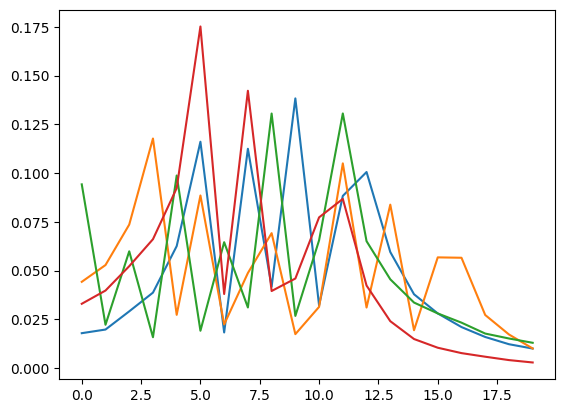

In [37]:
f_mean = np.mean(f.cpu().detach().numpy(), axis=0)
plt.plot(f_mean[0])
plt.plot(f_mean[1])
plt.plot(f_mean[2])
plt.plot(f_mean[3])
plt.show()

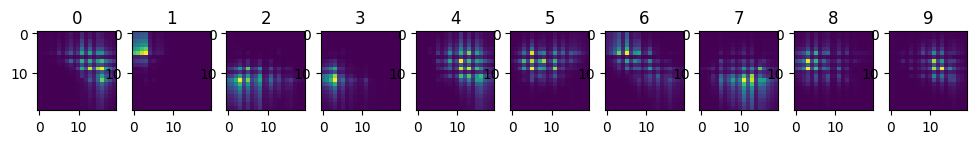

In [38]:
# plot
fig, axs = plt.subplots(1,10, figsize=(12,2))
for i in range(0,10):
    f1, f2 = f[::,0,::], f[::,1,::]
    probs = np.zeros((f1.shape[-1],f1.shape[-1]))
    # selecting the encoded distibution vectors
    f1_cls, f2_cls = f1[targets_test == i], f2[targets_test == i]
    for f1_vec, f2_vec in zip(f1_cls, f2_cls):
        probs += np.outer(f1_vec.cpu().detach().numpy(), f2_vec.cpu().detach().numpy())
            
    axs[i].imshow(probs)
#     axs[i].set_xticks(model.range.detach().numpy()/20)
#     axs[i].set_yticks(model.range.detach().numpy()/20)
    
    axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_2d_distribution.png')

plt.show()

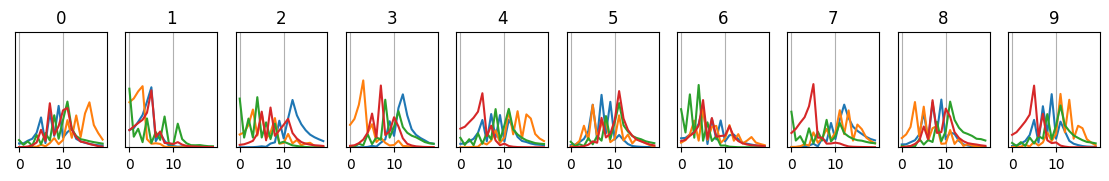

In [39]:
# plot
fig, axs = plt.subplots(1,10, figsize=(14,1.5), sharey=True)
for i in range(0,10):
#     axs[i].plot(model.range.detach().numpy()/20, np.mean(f.detach().numpy()[targets_test == i], axis=0)[0])
#     axs[i].plot(model.range.detach().numpy()/20, np.mean(f.detach().numpy()[targets_test == i], axis=0)[1])
    axs[i].plot(np.mean(f.cpu().detach().numpy()[targets_test == i], axis=0)[0])
    axs[i].plot(np.mean(f.cpu().detach().numpy()[targets_test == i], axis=0)[1])
    axs[i].plot(np.mean(f.cpu().detach().numpy()[targets_test == i], axis=0)[2])
    axs[i].plot(np.mean(f.cpu().detach().numpy()[targets_test == i], axis=0)[3])


    
    axs[i].grid(True)
    
#     axs[i].set_xticks([5,10,15])
    axs[i].set_yticks([])
    axs[i].set_ylim(0,0.5)

    axs[i].set_title(f'{i}')
plt.show()

In [40]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    ypred, out, enc, f = model(X_full.unsqueeze(1).to(device))  
    ypred1, out1, enc1, f1 = model(X_full_test.unsqueeze(1).to(device))       

    # celeb
    # ypred, out, enc, f = model(Faces_data_train.to(device))   
    # ypred1, out1, enc1, f1 = model(Faces_data_test.to(device))        

In [41]:
torch.mean(enc, dim=0)

tensor([0.3887, 0.4305, 0.3326, 0.3597, 0.3682, 0.4014, 0.4211, 0.3901],
       device='cuda:0')

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

enc_pca = pca.fit_transform(enc.cpu().detach().numpy())
enc_pca1 = pca.fit_transform(enc1.cpu().detach().numpy())

# enc_pca = enc.detach().numpy()
# enc_pca1 = enc1.detach().numpy()

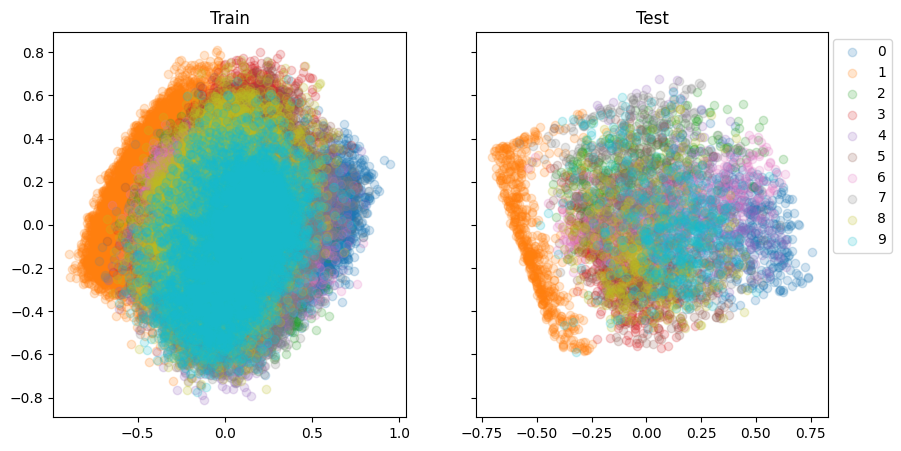

In [43]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_pca[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.2)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_pca1[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.2)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

In [44]:
torch.std(enc, dim=0).cpu()

tensor([0.2184, 0.2703, 0.2512, 0.2149, 0.1866, 0.2489, 0.2252, 0.2353])

In [45]:
EMB_SIZE = 8
PCA_SIZE = 2
pca = PCA(n_components=PCA_SIZE)
pca.fit(enc.cpu().detach().numpy())
pca.transform(torch.randn(1,EMB_SIZE)*torch.std(enc, dim=0).cpu() + torch.mean(enc, dim=0).cpu())

array([[-0.19120479,  0.2317967 ]])

In [46]:
enc_pca = pca.transform(enc.cpu().detach().numpy())
mean_enc_pca = np.mean(enc_pca, axis=0)
std_enc_pca = np.std(enc_pca, axis=0)
print(mean_enc_pca)
print(std_enc_pca)

[ 8.570057e-06 -6.239207e-06]
[0.29349184 0.26812214]


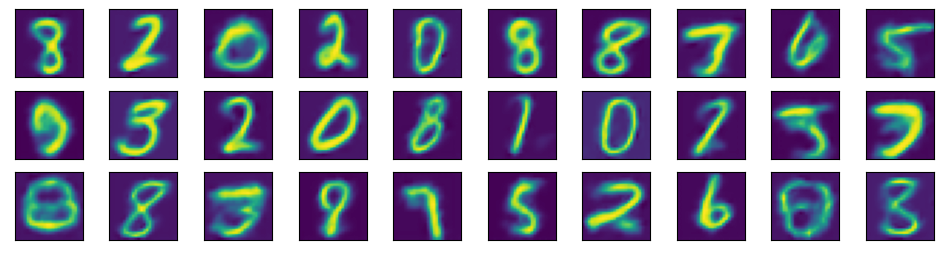

In [49]:
# plot
EMB_SIZE = 8

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()
        # res1 = model.low_rank.decoder((torch.tensor([[-0.5,-0.5,-0.5]])
        #                                +torch.tensor([[i*0.1, i*0.1, i*0.1]])).to(device))
        # res2d = model.up(res1.view(1,8,3,3))

        rand = torch.rand(EMB_SIZE)*0.9#*torch.std(enc, dim=0).cpu() + torch.mean(enc, dim=0).cpu()
        # noise = np.random.randn(2)*std_enc_pca + mean_enc_pca
        # rand = torch.tensor(pca.inverse_transform(noise), dtype=torch.float)
        res2 = model.low_rank.decoder(rand.to(device))
        res2d2 = model.up(res2.view(1,64,3,3))    # mnist
        # res2d2 = model.up(res2.view(1,256,4,4)) # celeb


        # rand = torch.randn(EMB_SIZE)*torch.std(enc, dim=0).cpu() + torch.mean(enc, dim=0).cpu()
        noise = np.random.randn(PCA_SIZE)*std_enc_pca + mean_enc_pca
        rand = torch.tensor(pca.inverse_transform(noise), dtype=torch.float)
        rand = torch.rand(EMB_SIZE)*0.9
        res3 = model.low_rank.decoder(rand.to(device))
        res2d3 = model.up(res3.view(1,64,3,3)) # mnist
        # res2d3 = model.up(res3.view(1,256,4,4))  # celeb


        # rand = torch.randn(EMB_SIZE)*torch.std(enc, dim=0).cpu() + torch.mean(enc, dim=0).cpu()
        noise = np.random.randn(PCA_SIZE)*std_enc_pca + mean_enc_pca
        rand = torch.tensor(pca.inverse_transform(noise), dtype=torch.float)
        rand = torch.rand(EMB_SIZE)*0.9
        res4 = model.low_rank.decoder(rand.to(device))
        res2d4 = model.up(res4.view(1,64,3,3)) # mnist
        # res2d4 = model.up(res4.view(1,256,4,4))  # celeb


        
    # mnist
    axs[0,i].imshow(res2d2.cpu().detach().numpy()[0,0])
    axs[1,i].imshow(res2d3.cpu().detach().numpy()[0,0])
    axs[2,i].imshow(res2d4.cpu().detach().numpy()[0,0])

    # celeb
    # axs[0,i].imshow(np.transpose(res2d2.cpu().detach().numpy()[0], (1,2,0)))
    # axs[1,i].imshow(np.transpose(res2d3.cpu().detach().numpy()[0], (1,2,0)))
    # axs[2,i].imshow(np.transpose(res2d4.cpu().detach().numpy()[0], (1,2,0)))


    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_Generation.png')
plt.show()

In [639]:
std_enc_pca

array([0.4259794 , 0.36456668], dtype=float32)

In [640]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    res = model.decoder(torch.tensor([1.,-1.]))

plt.figure(figsize=(3,3))
# plt.imshow(out[0].detach().numpy().reshape(8,8))
plt.imshow(res.detach().numpy().reshape(18,18))
plt.show()

AttributeError: 'ConvEncoder' object has no attribute 'decoder'

In [ ]:
fig, axs = plt.subplots(3,10, figsize=(12,6))
for i in range(10):
    axs[0,i].imshow(model.encoder[1].weight[i+0].reshape(18,18).detach().numpy())
    axs[1,i].imshow(model.encoder[1].weight[i+10].reshape(18,18).detach().numpy())
    axs[2,i].imshow(model.encoder[1].weight[i+20].reshape(18,18).detach().numpy())

    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
    
plt.show()